## SPIM data CEBRA model

- Use CEBRA label contrastive learning on neural data from one fish
    - design model
    - load data
    - SPIM data preprocessing
    - fit with label of the stimulus
    - plot embeddings
    - decode stimulus presence and type (left/right spots)<br/><br/>

### - labelled CEBRA with both discrete (second half of stimulus) and continuous (linear increase through stimulus) variables
### - Randomised the test set when using discontinuous data
### - implemented continuous 'time-since-last-stimulus' variable. One for each stimulus type
### - Here, setting the random seeds for np, python, and pytorch, to see what variable is in the output

### - finally, combining the continuous variable for discrete-and-continuous into a single stimulus-agnostic array

In [1]:
%matplotlib ipympl
import cebra
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import sklearn
from sklearn.model_selection import train_test_split
from pathlib import Path
import torch


In [2]:
### set random seeds ###
torch.manual_seed(10)
random.seed(10)
np.random.seed(10)

In [3]:
### define globals ### 

# list of all data files
dat_files = ['/media/storage/DATA/lfads_export/f1_221027.h5',
             '/media/storage/DATA/lfads_export/f1_221103.h5',
             '/media/storage/DATA/lfads_export/f2_221103.h5',
             '/media/storage/DATA/lfads_export/f3_221103.h5']

global LABEL                   # brief description of model training label
global EXTRA_LABEL             # optional extra information to include in model name
global FILEPATH                # path to data file
global DATA_PATH               # path to experimental data
global MODELPATH_ROOT          # folder path for models folder
global MODELPATH_DATE          # specific path within models folder
global MODEL_VER               # append version to model name for when saving multiple repeats
global FRAMERATE               # framerate of neural recording, Hz
global TIMESTEPS               # no. of neural timepoints to use
global ROIS                    # no. of ROIs to use 
global ITERS                   # model training iterations
global LOAD_DATA               # attempt to load pre-saved .npz data files
global SAVE_DATA               # save new .npz files when created
global LOAD_MODEL              # attempt to load model
global SAVE_MODEL              # save model to models folder
global SAVE_FIGS               # automatically save figures generated
global SAVE_FIGS_LABEL         # extra label to be added to figure names as they are saved
global STIM_TYPES              # dictionary of stim types to stim numbers
global STIMS                   # relevant stims for model
global TRAINING_TEST_SPLIT     # split fraction for embedding model
global STIM_LENGTH_FRAMES      # the length in frames of stimuli, assuming all stimuli have equal duration
global HALF_STIM_MASK          # only use the second half of stimuli for training the model
global DISCRETE_AND_CONT_STIM  # combine the discrete stimulus identifier variable with an linearly increasing 
                               # continuous variable.
                               # continuous variable is currently independent of other flags. It will e.g. not 
                               # be influenced by HALF_STIM_MASK
global PREDICT_ON_TRAIN        # for decoder, do both training and prediciton on the training set
global RESTRICT_TO_TECTAL      # get random subset of neurons from the tectal mask only
global TRIAL_TIME              # If True, use concatenated peri-trial timeseries instead of continuous timeseries
global SIGNAL_TYPE             # whether to use deconvolved calcium or raw calcium
global RANDOMISED_TEST         # when running on discontinuous data, randomise the order of the 'trials' for a 
                               # balanced test set
global TIME_SINCE_LAST         # continuous variable recording the time since last stimulus (of that type).
                               # not compatible with the discrete and continuous stim labelling

LABEL = 'spot'                                                          # set as '' for time-contrastive
EXTRA_LABEL = 'second-half-stims_deconv_discrete-and-cont_control-seed'
FILEPATH = dat_files[1]
DATA_PATH = '/home/tomh/Documents/projects/czebra/test_notebooks/data/'
MODELPATH_ROOT = '/home/tomh/Documents/projects/czebra/archived_models/'
MODELPATH_DATE = '231002/'
MODEL_VER = 2
FRAMERATE = 5
TIMESTEPS = None                                                        # set as None to use all timepoints
ROIS =  10000 #int(101435 * 0.50) 
ITERS = 2000
LOAD_DATA = True
SAVE_DATA = False
LOAD_MODEL = False
SAVE_MODEL = True
SAVE_FIGS = True
STIM_TYPES = {'left_spot':0, 'right_spot':1,  \
              'open_loop_grating':2, 'closed_loop_grating':3}
STIMS = ['left_spot', 'right_spot']
TRAINING_TEST_SPLIT = 0.8
STIM_LENGTH_FRAMES = 22
HALF_STIM_MASK = True
DISCRETE_AND_CONT_STIM = True       
PREDICT_ON_TRAIN = False
RESTRICT_TO_TECTAL = False
SAVE_FIGS_LABEL = 'predict-on-train_' if SAVE_FIGS and PREDICT_ON_TRAIN else ''
TRIAL_TIME = False
SIGNAL_TYPE = 'deconv'        # dfof for raw, deconv for deconvolved
RANDOMISED_TEST = False
TIME_SINCE_LAST = False

When loading data, the notebook will try to load the generic dataset with the name given by the chosen combination of flags. This is similar for loading the model, but it will also take into account the "extra label", to string match to the right model folder. Remember to set the extra label to match the chosen flags

In [4]:
### define model ###

parameters = {'conditional':'time_delta',
              'max_iterations':ITERS,
              'batch_size':1024,
              'num_hidden_units':128,
              'weight_decay':1e-03,
              'rois':ROIS,
             }

cebra_stim_on_model = cebra.CEBRA(
    model_architecture='offset10-model',
    device='cuda_if_available',
    conditional=parameters['conditional'],
    temperature_mode='auto',
    min_temperature=0.1,
    time_offsets=10,
    max_iterations=parameters['max_iterations'],
    max_adapt_iterations=500,
    batch_size=parameters['batch_size'],
    learning_rate=1e-4,
    output_dimension=3,
    verbose=True,
    num_hidden_units=parameters['num_hidden_units'],
    hybrid=False,
    optimizer_kwargs=(('betas', (0.9, 0.999)), ('eps', 1e-08), ('weight_decay', parameters['weight_decay']), ('amsgrad', False))
    )
print(cebra_stim_on_model)

CEBRA(batch_size=1024, conditional='time_delta', learning_rate=0.0001,
      max_iterations=2000, model_architecture='offset10-model',
      num_hidden_units=128,
      optimizer_kwargs=(('betas', (0.9, 0.999)), ('eps', 1e-08),
                        ('weight_decay', 0.001), ('amsgrad', False)),
      output_dimension=3, temperature_mode='auto', time_offsets=10,
      verbose=True)


### Functions for loading, saving and preprocessing model input data

In [5]:
def generate_neural_dataset(f, neural, rois, timesteps=None, restrict_to_tectal=None):  
    ''' Take a random sample of rois from either the tectal-restricted dataset or
        the full dataset. 
        If a number of timesteps are given, only index the neural data up to this value
        f                   - h5pyFile object for loading
        neural              - neural dataset from above file
        rois                - num rois to choose
        timesteps           - maximum index of neural in time dimension
        restrict_to_tectal  - flag for restricting dataset to tectum only'''
    
    # decide whether to sample from all neurons, or tectal neurons only
    if restrict_to_tectal:
        
        print("Taking tectal neurons only.")
        tectal_mask = f['rois']['anat_label']['tectum_SPV_AZ'][:]
        neural_indexes = np.sort(
                            np.random.choice(
                                            np.where(tectal_mask)[0], size=rois, replace=False
                                            )
                                )
    else:
        
        # subset neural by selecting first TIMESTEPS timesteps and random ROIS rois
        neural_indexes = np.sort(
                            np.random.choice(
                                        np.arange(neural.shape[1]), size=rois, replace=False
                                        )
                            )
    
    # if a subset of timesteps is chosen, restrict data to this subset
    if timesteps:
        neural = np.array(neural[:timesteps, neural_indexes])
    else:
        neural = np.array(neural[:, neural_indexes])
        timesteps = neural.shape[0]

    print(f"Truncated dataset size: {neural.shape}")
    assert(neural.shape == (timesteps, rois))

    return (neural, neural_indexes)

In [6]:
def create_stimulus_presentation_masks(f, neural, stims, stim_types, stim_length_frames, timesteps=None):
    ''' For every input stimulus type, find:
    - index value of the stimulus presentations
    - frame index of stimulus onset
    - frame index of stimulus end
    - the boolean mask for when this stimulus is being presented
    - the above 3 for the second half of the stimulus duration
    - the stimulus duration
      
    Second-half stimulus found by adding half of stimulus duration to onset frame numbers
    f                   - h5pyFile object for loading
    neural              - neural dataset from above file
    stims               - chosen stim types for this extraction (ArrayLike of ints for indexing stim_types)
    stim_types          - dict of stimulus types, indexed by stims
    stim_length_frames  - duration of stimuli (currently fixed for all stimuli)
    timesteps           - maximum index of neural in time dimension
    '''


     # get stimulus presentations
    stimuli = f['visuomotor']['presentations']
    stim_type = stimuli['stim_type'][:timesteps].astype(int)
    stim_on_fr = stimuli['onset_frame'][:timesteps].astype(int)
    stim_end_fr = stimuli['offset_frame'][:timesteps].astype(int)

    # initialise lists for the chosen stimuli
    (stim_pres_idx_list, stim_on_fr_list, 
    stim_on_fr_list_half,
    stim_end_fr_list, stim_on_mask_list, 
    stim_on_mask_list_half,
    stim_dur_list)                        = [],[],[],[],[],[],[]


    # loop through chosen stimuli and find boolean masks for their 'on' frames
    for stim in stims:

        # convert stim name to stim number
        stim_num = stim_types[stim] 
        print(f'Attempting to parse stim: {stim}') 

        # find the presentation indexes for the specified stim type
        # must account for data index starting at 1
        this_stim_pres_indexes = np.where(np.isin(stim_type, stim_num + 1))[0]
        stim_pres_idx_list.append(this_stim_pres_indexes)

        # index stim-specific onset frame numbers 
        this_stim_on_frames = stim_on_fr[this_stim_pres_indexes]
        if timesteps:
            this_stim_on_frames = this_stim_on_frames[this_stim_on_frames < timesteps]
        stim_on_fr_list.append(this_stim_on_frames)

        # Find also the second half of stimulus frames: increment the start frame
        # indexes by half the stimulus duration, to simulate the stimulus starting halfway
        # later than it actually does
        this_stim_on_frames_half = (this_stim_on_frames + stim_length_frames/2).astype(int)
        stim_on_fr_list_half.append(this_stim_on_frames_half)

        # index stim-specific end frame numbers 
        this_stim_end_frames = stim_end_fr[this_stim_pres_indexes]
        if timesteps:
            this_stim_end_frames = this_stim_end_frames[this_stim_end_frames < timesteps]
        stim_end_fr_list.append(this_stim_end_frames)
            

        # create a boolean mask of stimulus presentation frames (1 == stimulus on, 0 == stimulus off)
        # do this for second-half-stim and full stim
        this_stim_on_mask = np.zeros(neural.shape[0]).astype(int)
        this_stim_on_mask[[this_stim_on_frames, this_stim_end_frames]] = 1
        this_stim_on_mask_half = np.zeros(neural.shape[0]).astype(int)
        this_stim_on_mask_half[[this_stim_on_frames_half, this_stim_end_frames]] = 1
        
        # perform bitwise XOR operation on consecutive elements of stim_on_mask. This will convert all 
        # but stim_off frame to 1s. Combining with "OR stim_on_mask" will also include the stim_off frame
        this_stim_on_mask = np.bitwise_xor.accumulate(this_stim_on_mask) | this_stim_on_mask
        stim_on_mask_list.append(this_stim_on_mask)
        this_stim_on_mask_half = np.bitwise_xor.accumulate(this_stim_on_mask_half) | this_stim_on_mask_half
        stim_on_mask_list_half.append(this_stim_on_mask_half)
        
        # find duration (in frames) of each presentation of the stimulus
        # recording rate is 5 Hz
        stim_dur_list.append(this_stim_end_frames - this_stim_on_frames)

        # assert shapes
        print(f"Label shape: {stim_on_mask_list[0].shape}")
        print(f'Stim type {stim} parsed successfully.')

    return (stim_pres_idx_list, stim_on_fr_list, stim_on_fr_list_half,
            stim_end_fr_list, stim_on_mask_list, stim_on_mask_list_half,
                stim_dur_list)

In [7]:
def save_data_to_file(stim_on_mask_dataset, neural, neural_indexes, 
              data_folder, filename_stim_pres_frames, filename_neural_subset,
              filename_neural_indexes):   
    ''' Save data to the specified folder. This includes neural data, indexes of 
        neural ROIs, and a binary mask of stimulus activity
        stim_on_mask_dataset    - binary mask of stimulus activity (all stims)
        neural                  - neural dataset from above file
        neural_indexes          - index values of rois used in the dataset (w.r.t raw data)
        data folder              - maximum index of neural in time dimension
        filename_stim_pres_frames - flag for restricting dataset to tectum only
        data folder              - maximum index of neural in time dimension
        filename_stim_pres_frames - flag for restricting dataset to tectum only
    '''

    np.savez(f'{data_folder}{filename_stim_pres_frames}', stim_on_frames=stim_on_mask_dataset)
    print(f"Stim presentation dataset saved.")
    np.savez(f"{data_folder}{filename_neural_subset}", neural=neural)
    print(f"Neural dataset saved.")
    np.savez(f"{data_folder}{filename_neural_indexes}", neural_indexes=neural_indexes)
    print(f"All datasets saved.")

In [8]:
def load_data_from_file(filepath, data_folder, filename_neural_subset,
                        filename_stim_pres_frames):
    ''' Attempt to load .npz files for neural data and auxiliary variables'''
    
    key = "neural"
    try:
        # loading dataset from SSD (not HDD) here
        neural = cebra.load_data(f"{data_folder}{filename_neural_subset}", key=key)
        print("Neural data loaded")

    except:
        print(f"Could not neural data from file {data_folder}{filename_neural_subset} under key {key}.")
        try:
            # try loading directly from the .h5 file
            neural = cebra.load_data(filepath, key='rois/deconv')
            print("Full neural data loaded from HDD file.")

        except Exception as e:
            # give up
            print("Could not load data.")
            print(e)
    
    # auxiliary variables
    stim_on_frames = cebra.load_data(f'{data_folder}{filename_stim_pres_frames}', key="stim_on_frames")
    print(f"Stimulus presentation frames loaded.")
    print("All data loaded.")

    return (neural, stim_on_frames)

In [9]:
### load and preprocess data for a single fish ###
# if LOAD == True, load pre-saved .npz file data. Otherwise,
# create this data as specified below and save it to .npz

##  params ##

# variables
stim_types = STIM_TYPES     # dict of all possible stims
stims = STIMS               # stim types chosen for analysis
timesteps = TIMESTEPS
rois = ROIS
stim_length_frames = STIM_LENGTH_FRAMES # used for selecting the second half of stimuli

start, stop = 0, timesteps
load_data = LOAD_DATA
save_data = SAVE_DATA

# paths
filepath = FILEPATH
filename = filepath.split('/')[-1][:-3] # fish and date only
data_folder = DATA_PATH
data_folder_HDD = '/media/storage/DATA/tom/'
filename_stim_pres_frames = f'{filename[-9:]}_stim_pres_frames.npz'
filename_neural_subset = f'{filename[-9:]}_{SIGNAL_TYPE}_subset.npz'
filename_neural_indexes = f'{filename[-9:]}_neural_indexes_all.npz'

# specify loading anatomically unrestricted data or tectal-restricted data
if RESTRICT_TO_TECTAL:
    filename_neural_subset = f'{filename[-9:]}_{SIGNAL_TYPE}_subset_tectal.npz'
    filename_neural_indexes = f'{filename[-9:]}_neural_indexes_tectal.npz'

# if not loading data, but not wanting to overwrite saved data, save as a temp file
if not save_data and not load_data: 
    print(f"Producing temp files...")
    filename_neural = f'{filename[-9:]}_{SIGNAL_TYPE}_TEMPORARY_DELETE.npz'
    filename_neural_subset = f'{filename[-9:]}_{SIGNAL_TYPE}_subset_TEMPORARY_DELETE.npz'
    filename_stim_pres_frames = f'{filename[-9:]}_stim_pres_frames_TEMPORARY_DELETE.npz'


print("Accessing data...")

## load data ##
if load_data:
        
    # Attempt to load neural data from .npz, otherwise load from HDD .h5
    # Load small datasets from .npz files
    print("Loading data...")
    (neural, stim_on_frames) =  load_data_from_file(filepath, data_folder, filename_neural_subset,
                                                    filename_stim_pres_frames)


## else generate data ##
else:
    with h5py.File(filepath, 'r') as f:

            ## neural ##

            neural_dataset = f['rois'][f'{SIGNAL_TYPE}']
            print(f"Full neural dataset shape is: {neural_dataset.shape}")

            neural, neural_indexes = generate_neural_dataset(f, neural_dataset, rois, timesteps=timesteps,
                                                             restrict_to_tectal=RESTRICT_TO_TECTAL)

            ## stimuli ##

            (stim_pres_idx_list, 
             stim_on_fr_list,
             stim_on_fr_list_half,
             stim_end_fr_list, 
             stim_on_mask_list, 
             stim_on_mask_list_half,
             stim_dur_list) = create_stimulus_presentation_masks(f, neural, stims, stim_types,
                                                                stim_length_frames, timesteps)

            ## save data ##
            print("Saving data...")

            # choose which stim_on_mask to use (half or full)
            # stim_on_mask half will ignore the first half of stimuli for the rest
            # of the session
            if HALF_STIM_MASK:
                stim_on_mask_dataset = np.column_stack(stim_on_mask_list_half[:])
            else: 
                 stim_on_mask_dataset = np.column_stack(stim_on_mask_list[:])

            assert(stim_on_mask_dataset.shape == (neural.shape[0], len(stims)))
            if timesteps:
                assert(neural.shape == (timesteps, rois))

            save_data_to_file(stim_on_mask_dataset, neural, neural_indexes, 
              data_folder, filename_stim_pres_frames, filename_neural_subset,
              filename_neural_indexes)

            ## load data ##
            # Attempt to load neural data from .npz, otherwise load from HDD .h5
            # Load small datasets from .npz files
            print("Loading data...")
            
            (neural, stim_on_frames) = load_data_from_file(filepath, data_folder, filename_neural_subset,
                                                           filename_stim_pres_frames)
# end else   

Accessing data...
Loading data...


Neural data loaded
Stimulus presentation frames loaded.
All data loaded.


In [15]:
np.sort(np.concatenate(stim_on_fr_list)), stim_on_fr_list

(array([ 1657,  2417,  2822,  3277,  3792,  4407,  5077,  5782,  6497,
         7107,  7542,  8447,  9122,  9982, 10442, 11237, 11787, 12387,
        12937, 13657, 14372, 15042, 15717, 16287, 16747, 17192, 17912,
        18432, 18847, 19207, 19857, 20387, 20942, 21537, 22137, 22787,
        23247, 23952, 24397, 24922, 25562, 26212, 26722, 27552, 28162,
        28832, 29482, 29937, 30552, 31172, 31762, 32297, 32937, 33822,
        34502, 35212, 35687, 36347, 37032, 37467, 37882]),
 [array([ 1657,  2822,  3792,  5077,  6497,  7542,  9122, 10442, 11787,
         12937, 14372, 15717, 16747, 17912, 18847, 19857, 20942, 22137,
         23247, 24397, 25562, 26722, 28162, 29482, 30552, 31762, 32937,
         34502, 35687, 37032, 37882]),
  array([ 2417,  3277,  4407,  5782,  7107,  8447,  9982, 11237, 12387,
         13657, 15042, 16287, 17192, 18432, 19207, 20387, 21537, 22787,
         23952, 24922, 26212, 27552, 28832, 29937, 31172, 32297, 33822,
         35212, 36347, 37467])])

In [17]:
### data processing ###

# format the discrete variable
# left spot == 1, right spot == 2, no stimulus == 0 
left_spot, right_spot = stim_on_frames[:,0], stim_on_frames[:,1]
right_spot = np.multiply(right_spot, 2)
discrete = np.add(left_spot, right_spot)

# separate data into training and test
training_test_split = TRAINING_TEST_SPLIT
split_idx = int(np.round(neural.shape[0] * training_test_split))
neural_train, neural_test = neural[:split_idx, :], neural[split_idx:, :]
discrete_train, discrete_test = discrete[:split_idx], discrete[split_idx:]

# if set, create a separate continuous "contrast" variable for each stimulus, to train
# the CEBRA model on alongside the discrete variable
# This is INDEPENDENT of other flags. It will always give the true linear ramp from 
# stimulus onset to end
if DISCRETE_AND_CONT_STIM:
    
    ## COMMENTED OUT TO TRY THE STIMULUS-AGNOSTIC CONTINUOUS VARIABLE
    # print(f"Creating continuous 'contrast' variable for stimuli...")
    # with h5py.File(filepath, 'r') as f:
    #     (_,stim_on_fr_list,_,_,_,_,_) = create_stimulus_presentation_masks(f, neural, stims, 
    #                                                                     stim_types,
    #                                                             stim_length_frames, timesteps)
        
    # left_spot_cont = np.zeros(neural.shape[0])
    # right_spot_cont = np.zeros(neural.shape[0])
    # cont_stimuli = [left_spot_cont, right_spot_cont]
    # for i in range(len(cont_stimuli)):
    #     this_stim_on_fr = stim_on_fr_list[i]
    #     for pres in this_stim_on_fr:
    #         cont_stimuli[i][pres:pres+STIM_LENGTH_FRAMES] = np.arange(STIM_LENGTH_FRAMES)

    # # separate data into training and test
    # left_spot_cont_train, left_spot_cont_test =  left_spot_cont[:split_idx], left_spot_cont[split_idx:]
    # right_spot_cont_train, right_spot_cont_test = right_spot_cont[:split_idx], right_spot_cont[split_idx:]
    
    # # arange as expected input to CEBRA
    # cont_test = np.vstack((left_spot_cont_test, right_spot_cont_test)).T
    # cont_train = np.vstack((left_spot_cont_train, right_spot_cont_train)).T


        
    print(f"Creating continuous 'contrast' variable for stimuli...")

    # extract the stimulus onset frames
    with h5py.File(filepath, 'r') as f:
        (_,stim_on_fr_list,_,_,_,_,_) = create_stimulus_presentation_masks(f, neural, stims, 
                                                                        stim_types,
                                                                        stim_length_frames, timesteps)
    
    # initialise the continuous variable array and populate it for all frames xith a stimulus presentation
    spot_cont = np.zeros(neural.shape[0])
    stim_on_fr_list_agnostic = np.sort(np.concatenate(stim_on_fr_list))
    for i in range(len(stim_on_fr_list)):
        this_stim_idx = stim_on_fr_list_agnostic[i]
        spot_cont[this_stim_idx:this_stim_idx+STIM_LENGTH_FRAMES] = np.arange(STIM_LENGTH_FRAMES)

    # separate data into training and test
    cont_train, cont_test =  spot_cont[:split_idx], spot_cont[split_idx:]

    print(f"Created.")

if TIME_SINCE_LAST:

    print(f"Creating continuous 'time-since-last' variable for stimuli...")
    with h5py.File(filepath, 'r') as f:
        (_,stim_on_fr_list,_,_,_,_,_) = create_stimulus_presentation_masks(f, neural, stims, 
                                                                        stim_types,
                                                                stim_length_frames, timesteps)
    
    # initialise counting arrays
    time_since_last_spot_l = np.zeros(discrete.size)
    time_since_last_spot_r = np.zeros(discrete.size)
    time_since_last_stim_list = [time_since_last_spot_l, time_since_last_spot_r]

    # for each stimulus type
    for stim in range(len(stim_on_fr_list)):
        this_stim_on_fr = stim_on_fr_list[stim]
        time_since_last_stim = time_since_last_stim_list[stim]
        # loop through each stimulus in order
        for pres in this_stim_on_fr:
            # create counter
            counter = np.arange(pres, discrete.size)
            # overwrite the counting array with the counter
            # this will start a new count at the index of each stimulus presentation,
            # and continue counting until the end of the session, unless overwritten later
            # in the loop by another stimulus presentation
            time_since_last_stim[pres:] = counter - pres

    # separate data into training and test
    left_spot_cont_train, left_spot_cont_test = time_since_last_spot_l[:split_idx], time_since_last_spot_l[split_idx:]
    right_spot_cont_train, right_spot_cont_test = time_since_last_spot_r[:split_idx], time_since_last_spot_r[split_idx:]

    # arange as expected input to CEBRA
    cont_test = np.vstack((left_spot_cont_test, right_spot_cont_test)).T
    cont_train = np.vstack((left_spot_cont_train, right_spot_cont_train)).T

# end if


Creating continuous 'contrast' variable for stimuli...
Attempting to parse stim: left_spot
Label shape: (38550,)
Stim type left_spot parsed successfully.
Attempting to parse stim: right_spot
Label shape: (38550,)
Stim type right_spot parsed successfully.
Created.


In [25]:
# if cont_train:
#     fig, ax = plt.subplots(1,1)
#     plt.plot(cont_train[:,0])
#     plt.plot(cont_train[:,1])
#     plt.show()

In [26]:
### Create peri-stimulus "trials" ### 

if TRIAL_TIME:

    ## params ##
    pad = 4                      # time in s to pad either side of the stimulus in trial time
    dur = STIM_LENGTH_FRAMES     # length of stimulus in frames
    fr = FRAMERATE               # global recording framerate 

    # paths
    # separate stim on mask and neural data for this trial structure
    filename_neural_subset_trial_time = f'{filename[-9:]}_{SIGNAL_TYPE}_subset_trial_time.npz'
    filename_stim_on_mask_trial_time = f'{filename[-9:]}_stim_on_mask_trial_time.npz'


    ## access data ## 

    # create stimulus presentation masks, and find stimulus onset and end times
    with h5py.File(filepath, 'r') as f:

        (stim_pres_idx_list, 
            stim_on_fr_list,
            stim_on_fr_list_half,
            stim_end_fr_list, 
            stim_on_mask_list, 
            stim_on_mask_list_half,
            stim_dur_list)          = create_stimulus_presentation_masks(f, neural, stims, stim_types,
                                                                         stim_length_frames, timesteps=None)


    # for each stimulus, combine stim on and off times into the same array
    # (to get a general array of stimulus timings)
    spot_stim_on_frames = np.sort(np.concatenate([stim_on_fr_list[0], stim_on_fr_list[1]]))
    spot_stim_end_frames = np.sort(np.concatenate([stim_end_fr_list[0], stim_end_fr_list[1]]))

    # separate out stimulus ON masks into left spot and right 
    left_spot, right_spot = np.copy(stim_on_mask_list[0]), np.copy(stim_on_mask_list[1])
    left_spot_half, right_spot_half = np.copy(stim_on_mask_list_half[0]), np.copy(stim_on_mask_list_half[1])

    ## crop data into peri-trial time only ##

    # initialise numpy arrays (broadcast over rows)
    neural_list, discrete_list_left, discrete_list_right = np.zeros((3, spot_stim_on_frames.size), dtype='object')
    if DISCRETE_AND_CONT_STIM:
        cont_list_left, cont_list_right = np.zeros((2, spot_stim_on_frames.size), dtype='object')

    # for every stimulus presentation, crop neural and stimulus data to a window around the presentation
    # defined by stimulation duration, data framerate, and amount of padding (pad)
    for i in range(len(spot_stim_on_frames)):
        pres = spot_stim_on_frames[i]

        # neural
        neural_list[i] = neural[pres - pad*fr: pres + dur + pad*fr, :]
        
        # left spot
        # if taking second half of stims, crop the relevant array
        if HALF_STIM_MASK:
            discrete_list_left[i] = left_spot_half[pres - pad*fr: pres + dur + pad*fr]
        else:
            discrete_list_left[i] = left_spot[pres - pad*fr: pres + dur + pad*fr]
        if DISCRETE_AND_CONT_STIM:
            cont_list_left[i] = left_spot_cont[pres -pad*fr: pres + dur + pad*fr]
        
        # right spot
        # if taking second half of stims, crop the relevant array
        if HALF_STIM_MASK:
            discrete_list_right[i] = right_spot_half[pres - pad*fr: pres + dur + pad*fr]
        else:   
            discrete_list_right[i] = right_spot[pres - pad*fr: pres + dur + pad*fr]
        if DISCRETE_AND_CONT_STIM:
            cont_list_right[i] = right_spot_cont[pres -pad*fr: pres + dur + pad*fr]

    ## format data ##

    # format the discrete variable by combining stimuli
    # and set right spot value as 2 to differentiate from left spot
    discrete_list = np.zeros(discrete_list_left.size, dtype='object')
    for trial in range(discrete_list_left.size):
        right_spot_trial = np.multiply(discrete_list_right[trial], 2)
        discrete_list[trial] = np.add(discrete_list_left[trial], right_spot_trial)

    ## save data ##

    print("Saving trial-time data...")
    np.savez(f"{data_folder}{filename_neural_subset_trial_time}", neural_trial=neural_list)
    np.savez(f"{data_folder}{filename_stim_on_mask_trial_time}", stim_on_mask=discrete_list)
    print(f"All datasets saved.")

    ## training-test split ##

    # find the number of trials belonging to test and train sets
    training_test_split = TRAINING_TEST_SPLIT
    num_trials = int(len(neural_list))
    num_train_trials = int(np.floor(training_test_split*num_trials))

    # if only taking the last trials as test data
    if not RANDOMISED_TEST:

        # index lists with training and test indices
        train_trials_idx = np.arange(num_train_trials)
        test_trials_idx = np.arange(num_train_trials+1, num_trials)
        neural_train, neural_test = np.concatenate(neural_list[train_trials_idx]), np.concatenate(neural_list[test_trials_idx])
        discrete_train, discrete_test = np.concatenate(discrete_list[train_trials_idx]), np.concatenate(discrete_list[test_trials_idx])
        if DISCRETE_AND_CONT_STIM:
            cont_left_test, cont_right_test = np.concatenate(cont_list_left[test_trials_idx]), \
                                                np.concatenate(cont_list_right[test_trials_idx])
            cont_left_train, cont_right_train = np.concatenate(cont_list_left[train_trials_idx]), \
                                                np.concatenate(cont_list_right[train_trials_idx])

    # if taking a random subset of trials as test data
    elif RANDOMISED_TEST:

        # select random trials equal to the test set size
        num_test_trials = num_trials - num_train_trials
        test_trials_idx = np.random.choice(np.arange(num_trials), size=num_test_trials)
        # subtract the set of test trials from all trials to find the set of train trials
        train_trials_idx =  list(set(np.arange(num_trials)) - set(test_trials_idx))

        # index the lists of trials to create test and train data
        (neural_test, 
            discrete_test) = (np.concatenate(neural_list[test_trials_idx]),
                            np.concatenate(discrete_list[test_trials_idx]))
        (neural_train, 
            discrete_train) = (np.concatenate(neural_list[train_trials_idx]),
                            np.concatenate(discrete_list[train_trials_idx]))            
        if DISCRETE_AND_CONT_STIM:
            (cont_left_test,
                cont_right_test) = (np.concatenate(cont_list_left[test_trials_idx]),
                                    np.concatenate(cont_list_right[test_trials_idx]))
            (cont_left_train,
                cont_right_train) = (np.concatenate(cont_list_left[train_trials_idx]),
                                    np.concatenate(cont_list_right[train_trials_idx]))
    # end if/elif 

    if DISCRETE_AND_CONT_STIM:
        # if using continuous variable, format it as expected by CEBRA
        cont_test = np.vstack((cont_left_test, cont_right_test)).T
        cont_train = np.vstack((cont_left_train, cont_right_train)).T

else:
    print("Continuous data only.")

Continuous data only.


In [27]:
if TRIAL_TIME:
    fig = plt.figure(figsize=(10,4))
    # create a concatenated version for plotting
    neural_trial = np.concatenate(neural_list)
    discrete_trial = np.concatenate(discrete_list)
    plt.plot(np.mean(neural_trial[:], axis=1), label='mean neural activity')
    plt.plot(discrete_trial[:]/50, alpha=0.5, label='spot stimulus')
    plt.legend(loc='upper right', fontsize='small')

In [28]:
if TRIAL_TIME:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
    ax1.plot(np.mean(neural_list[45], axis=1))
    ax2.plot(neural_list[45])


In [29]:
### load, fit, and save model ###
# if LOAD_MODEL == True, load the specified model. Otherwise, fit the model
# and additionally save it if SAVE_MODEL == True

modelpath_root = MODELPATH_ROOT
modelpath_date = MODELPATH_DATE

# create model name and full model path
# model_name = 'f1_221103_spot-label_10000rois_2000iters_128hidden_1e-4L2'
model_name = f"{filename}_{LABEL}{'-label' if parameters['conditional'] == 'time_delta' else 'time'}_" + \
    f"{EXTRA_LABEL+'_' if EXTRA_LABEL else ''}" + \
    f"{ROIS}rois_{ITERS}iters_{parameters['num_hidden_units']}hidden_{parameters['weight_decay']}L2_" + \
    f"{TRAINING_TEST_SPLIT}train"
full_model_path = f"{modelpath_root}{modelpath_date}{model_name}/{model_name}_{MODEL_VER}.pt"
model_dir = f"{modelpath_root}{modelpath_date}{model_name}"

if LOAD_MODEL:

    ## load ##

    print("Loading model...")
    cebra_stim_on_model = cebra.CEBRA.load(full_model_path)
    print("Model loaded.")

    if SAVE_MODEL:

        ## save ##
        print("Saving model...")
        cebra_stim_on_model.save(full_model_path)
        print("Model saved.")

else:

    ## fit ## 

    print("Fitting model...")
    print(cebra_stim_on_model)

    if DISCRETE_AND_CONT_STIM:
        # cebra_stim_on_model.fit(neural_train, cont_train, discrete_train)
        cebra_stim_on_model.fit(neural_train, cont_train, discrete_train)

        print("discrete and continuous stimulus model fit.")

    elif TIME_SINCE_LAST:
        cebra_stim_on_model.fit(neural_train, cont_train)
        print("Time-since-last model fit.")

    else:
        print("Default training")
        cebra_stim_on_model.fit(neural_train, discrete_train)
        print("Discrete stimulus model fit.")


if SAVE_MODEL and not LOAD_MODEL:
    
    ## save ##

    print("Saving model...")
    # create the directory if it does not already exist (and continue if it does)
    Path(f"{model_dir}").mkdir(parents=True, exist_ok=True)
    cebra_stim_on_model.save(full_model_path)
    print("Model saved.")


Fitting model...
CEBRA(batch_size=1024, conditional='time_delta', learning_rate=0.0001,
      max_iterations=2000, model_architecture='offset10-model',
      num_hidden_units=128,
      optimizer_kwargs=(('betas', (0.9, 0.999)), ('eps', 1e-08),
                        ('weight_decay', 0.001), ('amsgrad', False)),
      output_dimension=3, temperature_mode='auto', time_offsets=10,
      verbose=True)


pos:  0.0279 neg:  6.0613 total:  6.0891 temperature:  0.8146: 100%|██████████| 2000/2000 [04:57<00:00,  6.72it/s]


discrete and continuous stimulus model fit.
Saving model...
Model saved.


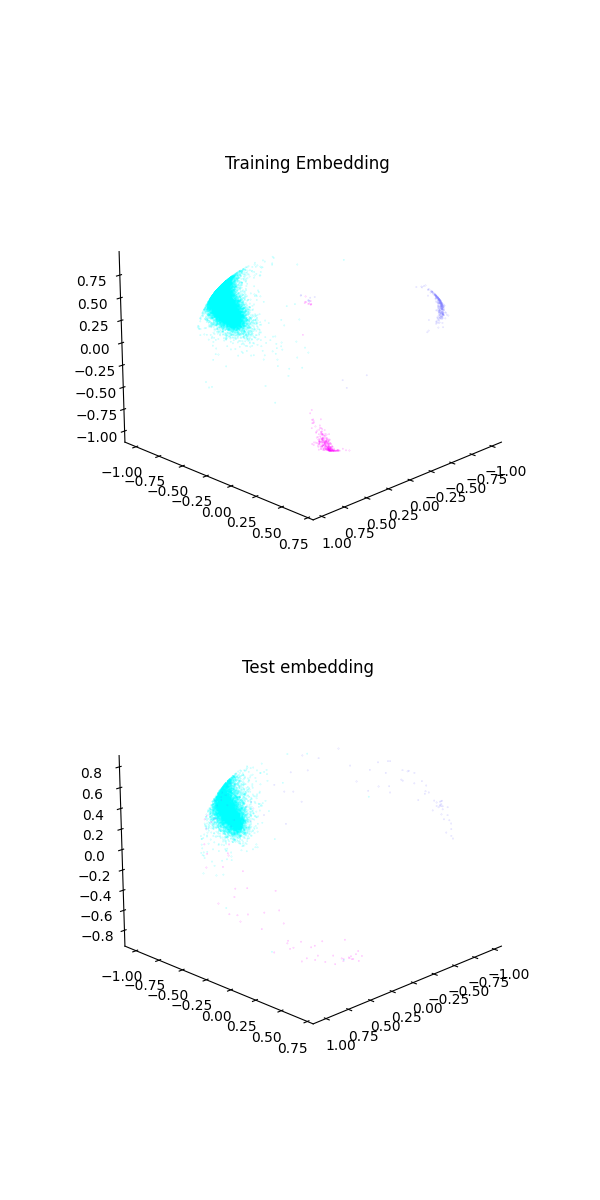

In [30]:
### generate/plot embeddings ###

# # CEBRA's plot_embedding function is bugged
fig = plt.figure(figsize=(6,12))
ax1 = plt.subplot(211, projection='3d')
ax2 = plt.subplot(212, projection='3d')
ax1.view_init(elev=20., azim=45)
ax2.view_init(elev=20., azim=45)

# trained embedding
embedding_train = cebra_stim_on_model.transform(neural_train)
cebra.plot_embedding(embedding=embedding_train, embedding_labels=discrete_train, ax=ax1, cmap='cool', title="Training Embedding")

# test embedding
embedding_test = cebra_stim_on_model.transform(neural_test)
cebra.plot_embedding(embedding=embedding_test, embedding_labels=discrete_test, ax=ax2, cmap='cool', title="Test embedding")

if SAVE_FIGS:
    # make folder if not already created
    try:
        os.mkdir(f"{model_dir}/v{MODEL_VER}/")
    except:
        pass
    # save this figure to the model folder
    plt.savefig(f"{model_dir}/v{MODEL_VER}/v{MODEL_VER}_{SAVE_FIGS_LABEL}embeddings")

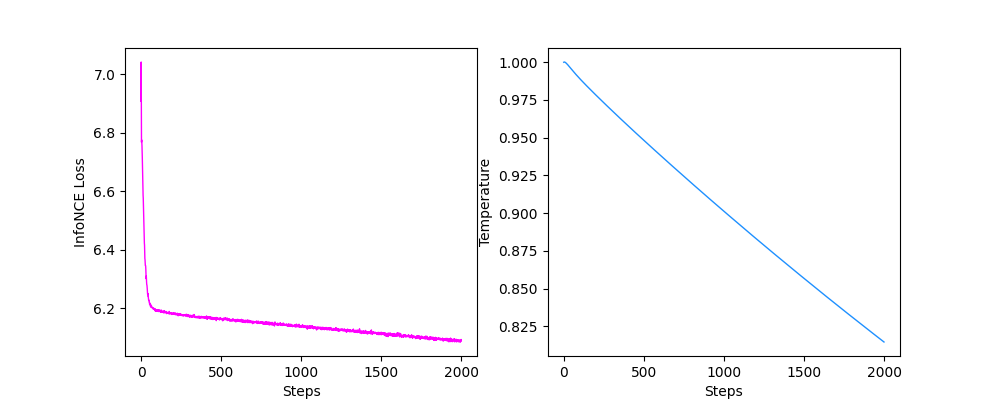

In [31]:
### plot loss and temperature ###

fig = plt.figure(figsize=(10,4))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

cebra.plot_loss(cebra_stim_on_model, ax=ax1)
cebra.plot_temperature(cebra_stim_on_model, ax=ax2)

if SAVE_FIGS:
    # save this figure to the model folder
    plt.savefig(f"{model_dir}/v{MODEL_VER}/v{MODEL_VER}_{SAVE_FIGS_LABEL}loss-and-temp")


In [32]:
### Decode ###

## set what should be predicted ##
# this should be function input
if TIME_SINCE_LAST:
    predicted_var = cont_train
else:
    predicted_var = discrete_train

if predicted_var.ndim > 1:
    predicted_var_subset = predicted_var[:,0]
else:
    predicted_var_subset = predicted_var

decoder = cebra.KNNDecoder()

decoder.fit(embedding_train, predicted_var_subset)

# decide whether to predict on the same embedding as trained on, or on the test embedding
if PREDICT_ON_TRAIN:
    # changed to predict on the training embedding
    predictions = decoder.predict(embedding_train)
    # also change what is considered the "test" set. In this case it will be the training set
    cont_test = cont_train
else:
    predictions = decoder.predict(embedding_test)

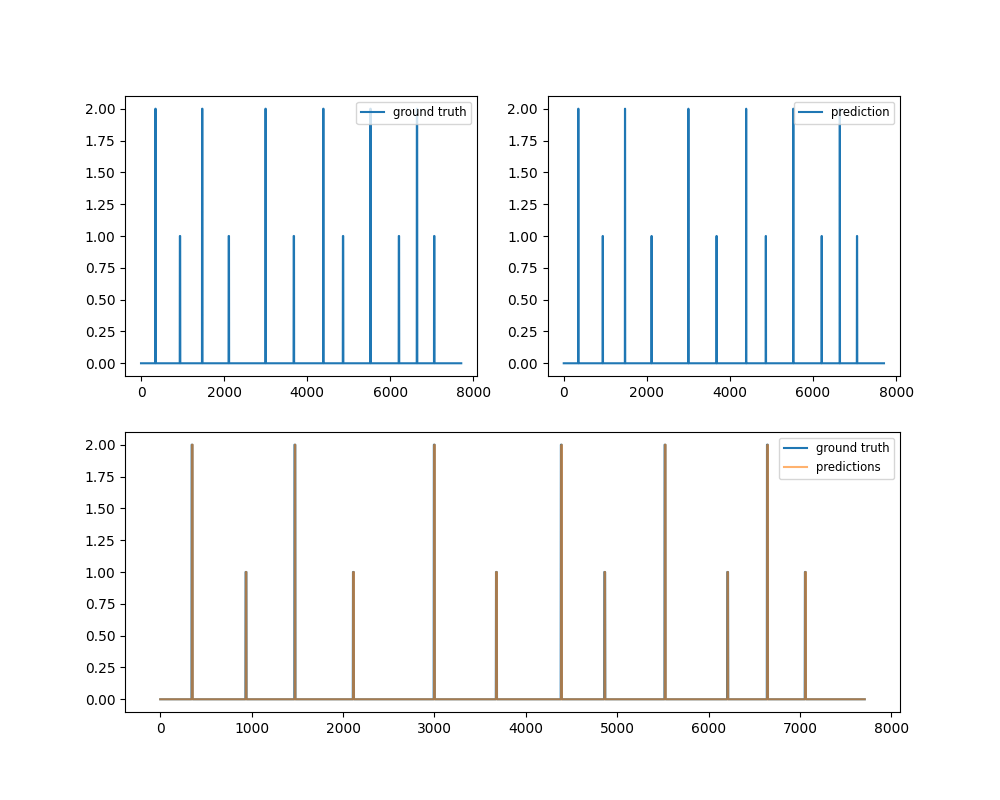

In [33]:
### visualise ###

fig = plt.figure(figsize=(10,8))
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,1,2)

ax1.plot(discrete_test, label='ground truth')
# ax1.plot(predictions, label='prediction')
ax1.legend(loc='upper right', fontsize='small')

ax2.plot(predictions, label='prediction')
ax2.legend(loc='upper right', fontsize='small')

ax3.plot(discrete_test, label='ground truth')
ax3.plot(predictions, label='predictions', alpha=0.6)
ax3.legend(loc='upper right', fontsize='small')

# ax3.text(7100, 1.00, f"f1 :{f1_score:.2f}", fontsize='small')
# ax3.text(7100, 0.9, f"f1_len :{lenient_f1_score:.2f}", fontsize='small')
# ax3.text(7100, 0.75, f"len-non-bi :{f1_score:.2f}", fontsize='small')

if SAVE_FIGS:
    # save this figure to the model folder
    plt.savefig(f"{model_dir}/v{MODEL_VER}/v{MODEL_VER}_{SAVE_FIGS_LABEL}predictions")

In [34]:
def create_lenient_predictions(test_data, prediction_data, stim_types, stim_length=22):
    ''' find the indexes where a prediction was made, and copy the ground truth
        for the relevant stimulus if this prediction lies within stimulus on '''
    
    leniency_range = stim_length*2
    predictions_lenient = np.zeros(prediction_data.size)

    stim_predictions = []
    for stim in stim_types:
        stim_predictions.append(np.where(np.isin(prediction_data, stim))[0])

    for i in range(len(stim_predictions)):
        # for each stimulus predicted
        prediction = stim_predictions[i]

        # for each index in current stimulus prediction
        for idx in prediction:
            # check if this is a correct prediction (ground-truth also the same stimulus category)
            if test_data[idx] == stim_types[i]:
                # for the leniency_range timepoints around the stimulus, copy any 1s from the ground truth to predictions
                upper_bound, lower_bound = np.ceil(idx+leniency_range/2).astype(int), np.ceil(idx-leniency_range/2).astype(int)
                predictions_lenient[lower_bound:upper_bound] = test_data[lower_bound:upper_bound]

    return predictions_lenient

In [35]:
### evaluate decoder performance - f1 score ###
# Also provide a lenient f1-score (where any prediction of a stimulus within 
# the stimulus duration counts as a fully accurate predictions)


## Define the test set ## 

# if cutting dead time, make sure to use the correct data
if TRIAL_TIME:
    # are we predicting on training data?
    if PREDICT_ON_TRAIN:
        # left_spot, right_spot = left_spot_trial[:split_idx], right_spot_trial[:split_idx]
        left_spot, right_spot = np.concatenate(discrete_list_left[train_trials_idx]),  \
                                np.concatenate(discrete_list_right[train_trials_idx])
        # # convert back to binary because right_spot_trial has been multiplied
        # right_spot = np.multiply(right_spot, 0.5).astype(int)
    else:
        # left_spot, right_spot = left_spot_trial[split_idx:], right_spot_trial[split_idx:]
        left_spot, right_spot = np.concatenate(discrete_list_left[test_trials_idx]),  \
                        np.concatenate(discrete_list_right[test_trials_idx])
        # # convert back to binary because right_spot_trial has been multiplied
        # right_spot = np.multiply(right_spot, 0.5).astype(int)
    
# if not cutting dead time, just load in stimulus masks
else:
    # are we predicting on training data?
    if PREDICT_ON_TRAIN:
        # for this case, set "test" subset of neural to just be the training subset 
        # index stim_on mask to restrict data to the test subset
        left_spot, right_spot = stim_on_frames[:split_idx,0], stim_on_frames[:split_idx,1]
    else:
        # index stim_on mask to restrict data to the test subset
        left_spot, right_spot = stim_on_frames[split_idx:,0], stim_on_frames[split_idx:,1]

# combine left and right spot stim_on mask
# identical stimulus values
discrete_test_f1_binary = np.add(left_spot, right_spot)
# different stimulus values
discrete_test_f1 = np.add(left_spot, np.multiply(right_spot, 2))


## convert predictions to be stimulus-agnostic for binary f1-score ## 

idx_to_replace = np.where(np.isin(predictions, 2))[0]
predictions_binary = np.copy(predictions)
predictions_binary[idx_to_replace] = 1


## calculate lenient predictions ##

predictions_binary_lenient = create_lenient_predictions(discrete_test_f1_binary, predictions_binary, stim_types=[1])
predictions_multiclass_lenient = create_lenient_predictions(discrete_test_f1, predictions, stim_types=[1,2])


## calculate binary f1-score ##

f1_score = sklearn.metrics.f1_score(discrete_test_f1_binary, predictions_binary)


## calculate lenient binary f1-score ##

f1_score_lenient = sklearn.metrics.f1_score(discrete_test_f1_binary, predictions_binary_lenient)


## calculate average multiclass f1-score ##

f1_score_multiclass = sklearn.metrics.f1_score(discrete_test_f1, predictions, 
                                                         average=None)
# find averages of the multiclass f1-score
f1_score_multiclass_average_stim = (f1_score_multiclass[1] + f1_score_multiclass[2])/2
f1_score_multiclass_average_all = (f1_score_multiclass[0] + f1_score_multiclass[1] + f1_score_multiclass[2])/3


## calcuate lenient average multiclass f1-score ##

f1_score_multiclass_lenient = sklearn.metrics.f1_score(discrete_test_f1, predictions_multiclass_lenient, 
                                                         average=None)
# find averages of the lenient multiclass f1-score
f1_score_multiclass_lenient_average_all = (f1_score_multiclass_lenient[0] + f1_score_multiclass_lenient[1])/2


## report f1-score ##

print(f"Strict f1-score:  {f1_score:.3f}\nLenient f1-score: {f1_score_lenient:.3f}\n"+
      f"Strict multiclass f1-score (stim-only avg): {f1_score_multiclass_average_stim:.3f}\n"+
      f"Strict multiclass f1-score (avg all): {f1_score_multiclass_average_all:.3f}\n"+
      f"Lenient multiclass f1-score (avg all): {f1_score_multiclass_lenient_average_all:.3f}\n")


## save f1-score ##
if SAVE_FIGS:
    with open(f"{model_dir}/v{MODEL_VER}/v{MODEL_VER}_{SAVE_FIGS_LABEL}f1-score.txt", 'w') as f:
        f.write(f"Strict f1-score:  {f1_score:.3f}\n")
        f.write(f"Lenient f1-score: {f1_score_lenient:.3f}\n")
        f.write(f"Strict multiclass f1-score (stim-only avg): {f1_score_multiclass_average_stim:.3f}\n")
        f.write(f"Strict multiclass f1-score (avg all): {f1_score_multiclass_average_all:.3f}\n")
        f.write(f"Lenient multiclass f1-score (avg all): {f1_score_multiclass_lenient_average_all:.3f}\n")


Strict f1-score:  0.753
Lenient f1-score: 1.000
Strict multiclass f1-score (stim-only avg): 0.752
Strict multiclass f1-score (avg all): 0.834
Lenient multiclass f1-score (avg all): 1.000



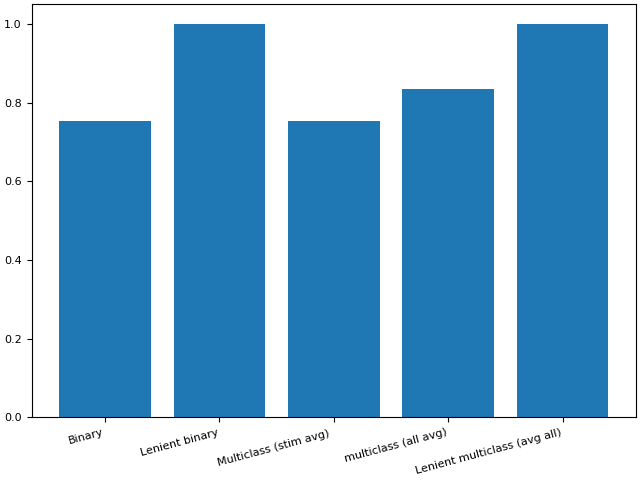

In [36]:
### quick bar chart code ###

f1_scores = [f1_score, f1_score_lenient, f1_score_multiclass_average_stim, f1_score_multiclass_average_all, f1_score_multiclass_lenient_average_all]
f1_score_descriptions = ['Binary', 'Lenient binary', 'Multiclass (stim avg) ', \
                          'multiclass (all avg)', 'Lenient multiclass (avg all)']


# plot
fig, ax = plt.subplots(layout="constrained")
ax.bar(x=np.arange(len(f1_scores)), height=f1_scores, tick_label=f1_score_descriptions)
ax.tick_params(labelsize=8)
plt.xticks(rotation=15, ha="right")
plt.show()

# save
if SAVE_FIGS:
    plt.savefig(f"{model_dir}/v{MODEL_VER}/v{MODEL_VER}_{SAVE_FIGS_LABEL}f1-score_bar-chart")
